# Supervised Autoencoder on CIFAR-10 — Notebook Template

**Goal:** Train a supervised autoencoder (reconstruction + classification) on CIFAR-10, with clear verification at each step.

> Fill in the TODOs step-by-step. Each section contains a brief checklist and sanity checks.

_Generated: 2025-10-21T11:48:40.685883Z_

## Environment & Reproducibility
- [ ] Select device (CPU/GPU)
- [ ] Set random seeds
- [ ] (Optional) Enable cudnn benchmark

**Verify:** print device; run a tiny tensor op.

In [1]:
import os
import math
import random
from pathlib import Path
import numpy as np
import random
import torch
import torchvision

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


## Config
- [ ] Define a simple config dict (dataset paths, batch size, latent_dim, λ, lr)
- [ ] Pri
nt config to confirm

**Tip:** Start simple; you can move this to YAML later.

In [2]:
# TODO: create a minimal config
CONFIG = {
    'data_root': '../data_02',
    'batch_size': 128,
    'augment': True,
    'num_workers': 4,
    'img_size': 32,
    'split_val': 0.8,
    'latent_dim': 64,          # try 32/128 later
    'lambda_recon': 0.25,      # weight for reconstruction loss
    'lr': 1e-3,
    'weight_decay': 1e-4,
    'epochs': 50,
}
from pprint import pprint
pprint(CONFIG)

{'augment': True,
 'batch_size': 128,
 'data_root': '../data_02',
 'epochs': 50,
 'img_size': 32,
 'lambda_recon': 0.25,
 'latent_dim': 64,
 'lr': 0.001,
 'num_workers': 4,
 'split_val': 0.8,
 'weight_decay': 0.0001}


## Data Pipeline (CIFAR-10)
- [ ] Define train/val/test transforms
- [ ] Build DataLoaders
- [ ] Print batch shapes and pixel ranges

**Verify:** `(B, 3, 32, 32)` and labels shape `(B,)`.

In [3]:
# TODO: write the strategy to explain the no normalization
from typing import Tuple
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset, random_split

def get_transforms(augment: bool = True):
    
    train_tfms = T.Compose([
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        ])
    
    test_val_tfms = T.Compose([
            T.ToTensor(),
        ])
    
    if augment is True:
        return train_tfms, test_val_tfms
    
    else:
        train_tfms = test_val_tfms
        return train_tfms, test_val_tfms
        
def get_dataloaders(cfg) -> Tuple[object, object, object]:

    train_tfms, test_tfms = get_transforms(cfg['augment'])
    
    # Instantiate the dataset
    test_set = CIFAR10(root=cfg['data_root'], train=False, transform= test_tfms, download = True)
    
    augment_train_set = CIFAR10(root=cfg['data_root'], train=True, transform= train_tfms, download = True)
    no_augment_train_set = CIFAR10(root=cfg['data_root'], train=True, transform= test_tfms, download = True)
    
    # split the full training data into train and validation sets
    train_size: int = int(cfg['split_val'] * len(augment_train_set))
    valid_size: int = len(augment_train_set) - train_size
    
    # get the list of indices
    dataset_indices = list(range(0, len(augment_train_set))) 

    random.seed(SEED)  
    shuffled_dataset_indices = random.sample(dataset_indices , k=len(dataset_indices))
    
    train_idx = shuffled_dataset_indices[:train_size]
    val_idx = shuffled_dataset_indices[train_size:]
    
    # Get the train_set and valid_set    
    train_set = Subset(dataset= augment_train_set, indices= train_idx)
    valid_set = Subset(dataset= no_augment_train_set, indices= val_idx)       
    
    # Instantiate the DataLoaders
    train_loader = DataLoader(
        dataset=train_set,
        batch_size=cfg["batch_size"],
        shuffle=True,               # always shuffle training data
        drop_last=True,             # optional but recommended for batchnorm stability
        pin_memory=True,            # speeds up transfers to GPU
        persistent_workers=True,    # avoids worker respawn overhead (if num_workers>0)
        num_workers=cfg["num_workers"]
    )
    
    valid_loader = DataLoader(
        dataset=valid_set,
        batch_size=cfg["batch_size"],
        shuffle=False,              # never shuffle validation data
        drop_last=False,
        pin_memory=True,
        persistent_workers=True,
        num_workers=cfg["num_workers"]
    )
    
    test_loader = DataLoader(
        dataset=test_set,
        batch_size=cfg["batch_size"],
        shuffle=False,
        drop_last=False,
        pin_memory=True,
        persistent_workers=True,
        num_workers=cfg["num_workers"]
    )
    
    # print dataset sizes
    print(f"All samples: {len(train_set)+len(valid_set)+len(test_set)}")
    print(f"Train samples: {len(train_set)}")
    print(f"Validation samples: {len(valid_set)}")
    print(f"Test samples: {len(test_set)}")

    # get one sample to check image shape
    image, label = augment_train_set[0]
    print(f"Single image shape: {image.shape}")
    
    return train_loader, valid_loader,test_loader

# Get the dataloader
train_loader, valid_loader,test_loader = get_dataloaders(CONFIG)
images, labels = next(iter(train_loader))

print(
    f"\n[INFO] Dataset summary:\n"
    f"       Images shape : {images.shape}\n"
    f"       Labels shape : {labels.shape}\n"
    f"       Pixel range  : [{images.min().item()}, {images.max().item()}]"
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
All samples: 60000
Train samples: 40000
Validation samples: 10000
Test samples: 10000
Single image shape: torch.Size([3, 32, 32])

[INFO] Dataset summary:
       Images shape : torch.Size([128, 3, 32, 32])
       Labels shape : torch.Size([128])
       Pixel range  : [0.0, 1.0]


## View a batch of images

Shape before transpose: (3, 546, 274)
Shape after transpose: (546, 274, 3)


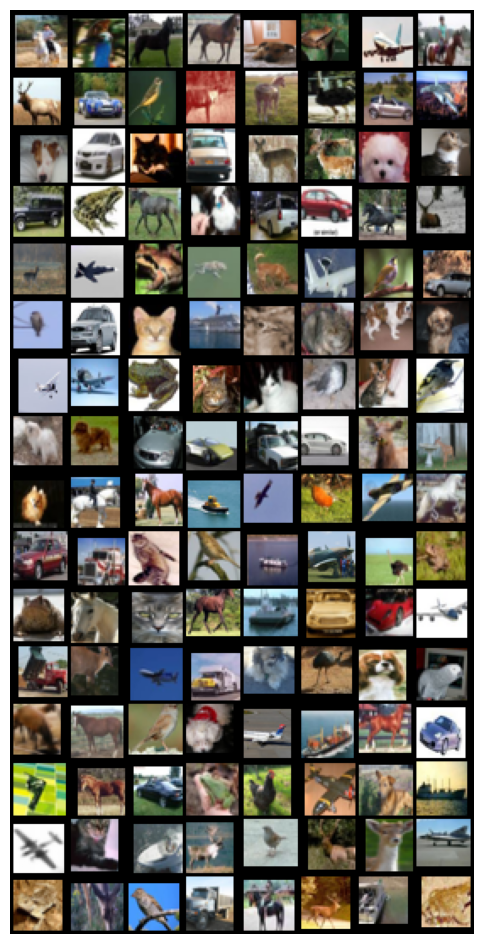

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# TODO: check the bug -> it is not an 8 by 8 figure, why?
# Helper function to display an image grid
def show_image(image_tensor: torch.Tensor) -> None:
    """Convert a PyTorch tensor into a viewable image grid and show it."""

    # Step 1 Undo normalization: normalised = (original - 0.5) / 0.5] -> normalised * 2 +0.5 = original
    # unnormalized_image_grid = image_tensor * 0.5 + 0.5

    # Step 2: Convert from a PyTorch tensor to a NumPy array (for matplotlib)
    # .detach() removes gradient tracking; .cpu() ensures data is on the CPU.
    image_grid_C_H_W = image_tensor.detach().cpu().numpy()
    
    print("Shape before transpose:", image_grid_C_H_W.shape)  
    # (C, H, W) → C = number of color channels (3 for RGB), H = height, W = width

    # Step 3: Rearrange dimensions from (C, H, W) to (H, W, C)
    # because Matplotlib expects the color channel as the last dimension.
    image_grid_H_W_C = np.transpose(image_grid_C_H_W, (1, 2, 0))
    print("Shape after transpose:", image_grid_H_W_C.shape)   # (H, W, C)

    # Step 4: Display the image
    plt.figure(figsize=(12, 12))
    plt.imshow(image_grid_H_W_C)
    plt.axis("off")  # hide axis numbers
    plt.show()
    
# Get a batch of training images
data_iter: iter = iter(train_loader)  # Create an iterator for the DataLoader
images: torch.Tensor
labels: torch.Tensor
images, labels = next(data_iter)   # Get one batch (images + labels)

# Make a grid from the batch
image_grid: torch.Tensor = torchvision.utils.make_grid(images, nrow=8)  # 8 images per row


# Show the grid
show_image(image_grid)

## Model — Encoder, Decoder, Classifier Head, SupervisedAE
- [ ] Implement `Encoder` → `z`
- [ ] Implement `Decoder` ← `z`
- [ ] Implement `ClassifierHead` (MLP on `z` → 10 logits)
- [ ] Implement `SupervisedAE.forward(x) → (z, x_hat, logits)`

**Verify:** Check shapes for a dummy batch.

In [17]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, latent_dim: int = 64):
        super().__init__()
        # TODO: conv → bn → relu blocks with downsampling to small spatial map
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
        )
        # 32→16→8→4
        self.flat_dim = 128*4*4 # = 2048
                
        # Learnable linear projection: compress 2048-dim feature vector → latent_dim embedding (bottleneck)
        self.to_latent = nn.Linear(self.flat_dim, latent_dim)
        
    def forward(self, x):
        # return z the latent vector of shape (B, latent_dim)
        features = self.encoder_cnn(x)
        features_flat = features.flatten(1)
        z = self.to_latent(features_flat)
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_dim: int = 64):
        super().__init__()
        # linear → reshape → convtranspose blocks back to (B,3,32,32)
        
        self.flat_dim = 128*4*4 # = 2048
        
        self.to_feature_vector = nn.Linear(latent_dim, self.flat_dim, )
        
        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2,padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, z):
        # return recon_features (x_hat) in [0,1] if using BCE, or unbounded for MSE
        features =self.to_feature_vector(z).reshape(z.size(0), 128, 4, 4) 
        recon_features = self.decoder_cnn(features)
    
        return recon_features

In [18]:
# Check: Encoder class
random_tensor = torch.rand(size = (8, 3, 32, 32))
encoder_trial = Encoder(latent_dim = 64)
latent_vector = encoder_trial.forward(random_tensor)
print("expected latent vector shape:",latent_vector.shape)

# Check: Decoder class
decoder_trial = Decoder()
recon_tensor = decoder_trial.forward(latent_vector)
print("expected reconstructed shape:", recon_tensor.shape)

expected latent vector shape: torch.Size([8, 64])
expected reconstructed shape: torch.Size([8, 3, 32, 32])


In [ ]:
class ClassifierHead(nn.Module):
    def __init__(self, latent_dim: int = 64, num_classes: int = 10):
        super().__init__()
        # STEP 1: Choose a hidden width for the MLP (common: 128 or 256).
        #   Rationale: small but expressive layer on top of z.
        #   Example (when you implement): hidden_dim = 128
        self.hidden_dim = 128
        
        # multilayer perceptron       
        self.mlp = nn.Sequential(
            nn.Linear()
        )

        # STEP 2: Define an MLP that maps z → logits:
        #   a) Linear(latent_dim → hidden_dim)
        #   b) (Optional) BatchNorm1d(hidden_dim)  # helps stabilize if batch size is decent
        #   c) Activation: ReLU() or LeakyReLU(0.1)
        #   d) (Optional) Dropout(p=0.1–0.3)       # regularization if overfitting
        #   e) Linear(hidden_dim → num_classes)
        # Store it as: self.mlp = nn.Sequential(...)

        # STEP 3 (Optional): Weight init
        #   - Kaiming init for Linear layers (fan_in), zeros for biases.
        #   - Only do this after shapes work; not required for correctness.

        raise NotImplementedError("Build the ClassifierHead (define self.mlp)")

    def forward(self, z):
        # STEP 4: (Sanity) Ensure z has shape (B, latent_dim).
        #   - You can add an assert or rely on downstream errors if mismatched.

        # STEP 5: Pass z through the MLP to get logits (unnormalized scores).
        #   - logits = self.mlp(z)

        # STEP 6: Return logits WITHOUT softmax.
        #   - Reason: nn.CrossEntropyLoss expects raw logits and applies log-softmax internally.

        raise NotImplementedError("Return logits from self.mlp(z)")


In [ ]:
class ClassifierHead(nn.Module):
    def __init__(self, latent_dim: int = 64, num_classes: int = 10):
        super().__init__()
        # STEP 1: Choose a hidden width for the MLP (common: 128 or 256).
        #   Rationale: small but expressive layer on top of z.
        #   Example (when you implement): hidden_dim = 128

        # STEP 2: Define an MLP that maps z → logits:
        #   a) Linear(latent_dim → hidden_dim)
        #   b) (Optional) BatchNorm1d(hidden_dim)  # helps stabilize if batch size is decent
        #   c) Activation: ReLU() or LeakyReLU(0.1)
        #   d) (Optional) Dropout(p=0.1–0.3)       # regularization if overfitting
        #   e) Linear(hidden_dim → num_classes)
        # Store it as: self.mlp = nn.Sequential(...)

        # STEP 3 (Optional): Weight init
        #   - Kaiming init for Linear layers (fan_in), zeros for biases.
        #   - Only do this after shapes work; not required for correctness.

        raise NotImplementedError("Build the ClassifierHead (define self.mlp)")

    def forward(self, z):
        # STEP 4: (Sanity) Ensure z has shape (B, latent_dim).
        #   - You can add an assert or rely on downstream errors if mismatched.

        # STEP 5: Pass z through the MLP to get logits (unnormalized scores).
        #   - logits = self.mlp(z)

        # STEP 6: Return logits WITHOUT softmax.
        #   - Reason: nn.CrossEntropyLoss expects raw logits and applies log-softmax internally.

        raise NotImplementedError("Return logits from self.mlp(z)")

In [ ]:
# TODO: define the model classes (use small CNN blocks suitable for CIFAR-10)
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, latent_dim: int = 64):
        super().__init__()
        # TODO: conv → bn → relu blocks with downsampling to small spatial map
        # self.feature_extractor = ...
        # self.to_latent = nn.Linear(flat_dim, latent_dim)
        raise NotImplementedError('Build the Encoder')
    def forward(self, x):
        # TODO: return z of shape (B, latent_dim)
        raise NotImplementedError

class Decoder(nn.Module):
    def __init__(self, latent_dim: int = 64):
        super().__init__()
        # TODO: linear → reshape → convtranspose blocks back to (B,3,32,32)
        raise NotImplementedError('Build the Decoder')
    def forward(self, z):
        # TODO: return x_hat in [0,1] if using BCE, or unbounded for MSE
        raise NotImplementedError

class ClassifierHead(nn.Module):
    def __init__(self, latent_dim: int = 64, num_classes: int = 10):
        super().__init__()
        # TODO: MLP on z → logits
        raise NotImplementedError('Build the ClassifierHead')
    def forward(self, z):
        raise NotImplementedError

class SupervisedAE(nn.Module):
    def __init__(self, latent_dim: int = 64, num_classes: int = 10):
        super().__init__()
        # TODO: compose encoder, decoder, head
        raise NotImplementedError('Assemble SupervisedAE')
    def forward(self, x):
        # TODO: return z, x_hat, logits
        raise NotImplementedError

# TODO: sanity check shapes with a dummy input once implemented
# x = torch.randn(8, 3, CONFIG['img_size'], CONFIG['img_size']).to(device)
# model = SupervisedAE(CONFIG['latent_dim']).to(device)
# with torch.no_grad():
#     z, x_hat, logits = model(x)
# print(z.shape, x_hat.shape, logits.shape)

## Losses
- [ ] Reconstruction loss (MSE or BCE)
- [ ] Classification loss (CrossEntropy)
- [ ] Total loss = CE + λ * Recon (+ optional L2 on z)

**Verify:** scalar outputs; grads flow to encoder/decoder/head.

In [ ]:
# TODO: implement loss functions
def reconstruction_loss(x_hat, x, loss_type='mse'):
    # TODO: return mse or bce
    raise NotImplementedError

def classification_loss(logits, y):
    # TODO: return cross entropy
    raise NotImplementedError

def total_loss(logits, x_hat, y, x, lambda_recon: float = 0.25, loss_type='mse'):
    # TODO: combine
    raise NotImplementedError

## Training Loop
- [ ] Build optimizer + (optional) scheduler
- [ ] Train for N epochs, log running losses & accuracy
- [ ] Validate each epoch; keep best checkpoint

**Verify:** both CE and recon losses decrease; accuracy > random.

In [ ]:
# TODO: implement train_one_epoch, evaluate, fit
def train_one_epoch(model, loader, optimizer, cfg):
    # TODO: loop over batches; compute losses; backprop; return logs
    raise NotImplementedError

def evaluate(model, loader, cfg):
    # TODO: compute val accuracy and recon loss
    raise NotImplementedError

def fit(model, train_loader, val_loader, cfg):
    # TODO: manage epochs, checkpoint best model
    raise NotImplementedError

# TODO: run training once everything above is ready
# model = SupervisedAE(CONFIG['latent_dim']).to(device)
# opt = torch.optim.Adam(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
# history = fit(model, train_loader, val_loader, CONFIG)

## Evaluation & Visual Checks
- [ ] Test accuracy (top-1, optionally top-5)
- [ ] Reconstruction quality (grid of originals vs reconstructions)
- [ ] Extract latents `z` and visualize (PCA/UMAP/t-SNE)

**Verify:** supervised AE should show more separated clusters than AE-only.

In [ ]:
# TODO: implement helper functions
def test_accuracy(model, loader):
    # TODO: compute top-1 accuracy
    raise NotImplementedError

def show_reconstructions(model, loader, n=8):
    # TODO: create and display/save a grid of reconstructions
    raise NotImplementedError

def extract_latents(model, loader):
    # TODO: concatenate z and labels
    raise NotImplementedError

def plot_latent_2d(Z, y, method='pca'):
    # TODO: reduce to 2D and plot (matplotlib)
    raise NotImplementedError

## Ablations & Baselines
- [ ] Classifier-only baseline (λ=0; no decoder)
- [ ] AE-only baseline (train AE, then MLP on frozen z)
- [ ] Supervised AE (main), sweep λ ∈ {0.1, 0.25, 0.5, 1.0}, latent_dim ∈ {32,64,128}

**Record:** accuracy, recon MSE, and latent plots per setting.

## Logging & Checkpoints
- [ ] Save per-epoch metrics (CSV/JSON)
- [ ] Save best model by val accuracy
- [ ] (Optional) TensorBoard

**Verify:** resume training from checkpoint works.

## Notes & Next Steps
- Try label smoothing, dropout, or weight decay tweaks
- Try different reconstruction loss (BCE vs MSE)
- Try data augmentation on/off
- Try OOD score via distance to class centroids in latent space
- Consider VAE version (KL term) once supervised AE is stable